In [1]:
#@title Importing libraries and defining classes

from edlut import simulation_wrapper as pyedlut
import os
import sys
from datetime import datetime
import time

# from pyedlut_STDE_hw import simulation_wrapper as pyedlut
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
})
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy.io import savemat

import pickle
import itertools

from tqdm import tqdm

from network_model_generalized import *

In [2]:
#@title Creating the network
net = MasquelierNetSin()

net.stop_simulation_at = 1000.0
net.seed = 1
net.n_outputs = 16 

net.max_weight=0.0081116117
net.syn_pre_inc=0.0000099384
net.learning_rate=0.0024703561
net.tau_thr=134.5163592812
net.tar_fir_rat=1.4808285384
net.k_plu_hig_d1=1.0000000000
net.k_min_hig_d1=-0.9375573822
net.k_plu_low_d1=-0.1823477854
net.k_min_low_d1=-0.2813546884
net.k_plu_hig_d2=-0.4148738924
net.k_min_hig_d2=0.1478506270
net.k_plu_low_d2=0.5717884478
net.k_min_low_d2=0.4226480316

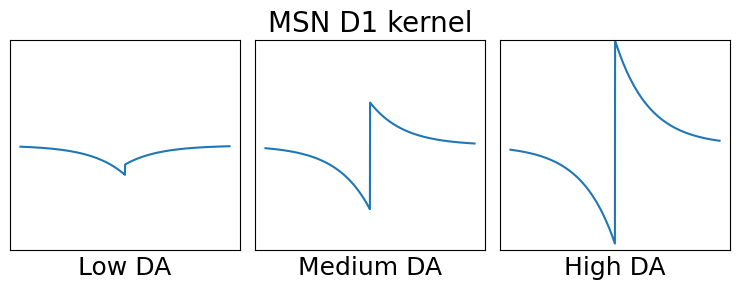

Integration of the kernels: -0.0919921155766611


In [3]:
#@title Plotting MSN D1 kernels
total = 0.0

kph = net.k_plu_hig_d1
kpl = net.k_plu_low_d1
kmh = net.k_min_hig_d1
kml = net.k_min_low_d1

max_k = np.max(np.abs(np.array((kph, kpl, kmh, kml))))

plt.rcParams['figure.figsize'] = (2.5*3,3)
fig, axs = plt.subplots(1,3)
for ax in axs:
    ax.set_ylim((-max_k, max_k))

x = np.linspace(-0.1,0.1, num=1000)
y = np.zeros_like(x)

y[x>0] = (kpl)*np.exp(-np.abs(x[x>0])/net.tau_plu)
y[x<0] = (kml)*np.exp(-np.abs(x[x<0])/net.tau_min)
total += np.sum(y)
axs[0].plot(x, y)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('Low DA', fontsize=18)

axs[1].set_title('MSN D1 kernel', fontsize=20)
y[x>0] = (kpl*0.5 + kph*0.5)*np.exp(-np.abs(x[x>0])/net.tau_plu)
y[x<0] = (kml*0.5 + kmh*0.5)*np.exp(-np.abs(x[x<0])/net.tau_min)
total += np.sum(y)
axs[1].plot(x, y)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlabel('Medium DA', fontsize=18)

y[x>0] = (kph)*np.exp(-np.abs(x[x>0])/net.tau_plu)
y[x<0] = (kmh)*np.exp(-np.abs(x[x<0])/net.tau_min)
total += np.sum(y)
axs[2].plot(x, y)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel('High DA', fontsize=18)

plt.tight_layout()
plt.show()
print('Integration of the kernels: {}'.format(total/x.size))

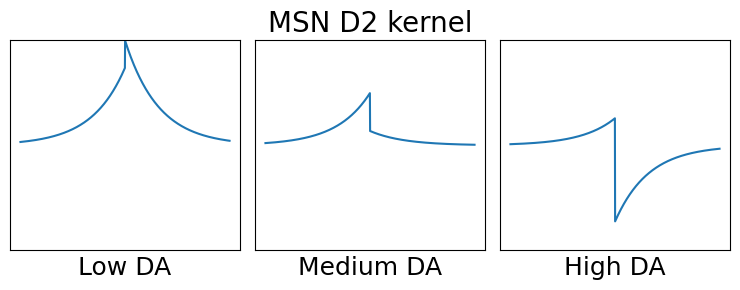

Integration of the kernels: 0.16676545000374648


In [4]:
#@title Plotting MSN D2 kernels
total = 0.0

kph = net.k_plu_hig_d2
kpl = net.k_plu_low_d2
kmh = net.k_min_hig_d2
kml = net.k_min_low_d2

max_k = np.max(np.abs(np.array((kph, kpl, kmh, kml))))

plt.rcParams['figure.figsize'] = (2.5*3,3)
fig, axs = plt.subplots(1,3)
for ax in axs:
    ax.set_ylim((-max_k, max_k))

x = np.linspace(-0.1,0.1, num=1000)
y = np.zeros_like(x)

y[x>0] = (kpl)*np.exp(-np.abs(x[x>0])/net.tau_plu)
y[x<0] = (kml)*np.exp(-np.abs(x[x<0])/net.tau_min)
total += np.sum(y)
axs[0].plot(x, y)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('Low DA', fontsize=18)

axs[1].set_title('MSN D2 kernel', fontsize=20)
y[x>0] = (kpl*0.5 + kph*0.5)*np.exp(-np.abs(x[x>0])/net.tau_plu)
y[x<0] = (kml*0.5 + kmh*0.5)*np.exp(-np.abs(x[x<0])/net.tau_min)
total += np.sum(y)
axs[1].plot(x, y)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlabel('Medium DA', fontsize=18)

y[x>0] = (kph)*np.exp(-np.abs(x[x>0])/net.tau_plu)
y[x<0] = (kmh)*np.exp(-np.abs(x[x<0])/net.tau_min)
total += np.sum(y)
axs[2].plot(x, y)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel('High DA', fontsize=18)

plt.tight_layout()
plt.show()
print('Integration of the kernels: {}'.format(total/x.size))

In [ ]:
#@title Running the simulation

net.init_simulation()
net.run()

file_truncated = False

OpenMP support is enabled


 52%|████████████████████▎                  | 2232/4278 [20:36<21:13,  1.61it/s]

In [8]:
net.save_data()

In [9]:
#@title Plotting spikes
def plot_spikes(self, t=-1, dt=1.0):
    
    # Configuración general

    import matplotlib.transforms as mtransforms
    if t is None or t<0: t = self.stop_simulation_at-dt
    plt.rcParams['figure.figsize'] = (12,7)

    fig, axs = plt.subplots(
        3+self.n_actions, 1, sharex=True, 
        gridspec_kw={'height_ratios': [0.5] + [0.75]*(self.n_actions) + [0.5]*2})

    # Patrón de entrada

    legend_list = []
    pattern_texture = {
        1: ('orange', 'white'),
        2: ('orange', 'black'),
        3: ('blue', 'white'),
        4: ('blue', 'black'),
        5: ('grey', 'white'),
    }
    for p in range(1,self.n_input_patterns+1):
        fill_pattern = np.roll(np.repeat(self.show_pattern==p, 2), 1)
        trans = mtransforms.blended_transform_factory(axs[0].transData, axs[0].transAxes)
        axs[0].fill_between(
            np.repeat(self.cumsum_input_duration_patterns, 2),
            0, 1,
            where=fill_pattern,
            facecolor=pattern_texture[p][0], alpha=0.5, transform=trans,
            hatch='xxxx', edgecolor=pattern_texture[p][1], linewidth=0.0,
        )
#         legend_list.append(mpatches.Patch(color=colors[p-1], label='Pattern {}'.format(p)))
        legend_list.append(
            mpatches.Patch(
                facecolor=pattern_texture[p][0], 
                label='Pattern {}'.format(p),
                hatch='xxxx', edgecolor=pattern_texture[p][1], linewidth=0.0,
                alpha=0.5,
            )
        )
    axs[0].legend(handles=legend_list, loc='upper right', ncol=3)

    # Raster plot de los spikes de entrada

    tim = (self.ot>=t) * (self.ot<=(t+dt))
    inp = (self.oi<self.input_layer[-1]) * ((self.oi%(self.n_inputs//20))==0)

    if dt<=4:
        axs[0].scatter(self.ot[inp*tim], self.oi[inp*tim], s=4.0, alpha=0.5)
    axs[0].set_yticks([])
    axs[0].set_title('Input activity')    

    
    for j in range(self.n_actions):
    
        # Actividad de las neuronas de grupos A y B
        
        ax_ = axs[1+j].twinx()
        msnd1 = self.output_layer[j*self.n_outputs:(j+1)*self.n_outputs:2]
        sub = (self.ot>=t)*(self.ot<=(t+dt)) * np.in1d(self.oi, msnd1)
        x, out = smooth_spikes(t,dt, self.ot[sub], sigma_s=50.0)
        ax_.plot(x, out, color='red blue'.split()[j])
        ax_.set_ylabel('Firing rate\n(Hz)', rotation=0, labelpad=30)

        msnd2 = self.output_layer[j*self.n_outputs+1:(j+1)*self.n_outputs:2]
        sub = (self.ot>=t)*(self.ot<=(t+dt)) * np.in1d(self.oi, msnd2)
        x, out = smooth_spikes(t,dt, self.ot[sub], sigma_s=50.0)
        ax_.plot(x, out, color='black black'.split()[j])
        ax_.set_ylabel('Firing rate\n(Hz)', rotation=0, labelpad=30)

        # Actividad media de neuronas de salida D1 y D2

        for i, n in enumerate(self.output_layer[j*self.n_outputs:(j+1)*self.n_outputs:2]):
            out = self.oi==n
            axs[1+j].scatter(
                self.ot[out*tim], -self.oi[out*tim], 
                s=10.0, color='lightcoral' if j==0 else 'skyblue', label='Output {}'.format(i+1))
            axs[1+j].axes.get_yaxis().set_visible(False)
        for i, n in enumerate(self.output_layer[j*self.n_outputs+1:(j+1)*self.n_outputs:2]):
            out = self.oi==n
            axs[1+j].scatter(
                self.ot[out*tim], -self.oi[out*tim], 
                s=10.0, color='darkgray' if j==0 else 'darkgray', label='Output {}'.format(i+1))
            axs[1+j].axes.get_yaxis().set_visible(False)
        # if self.n_outputs<4: axs[1+j].legend(loc='upper right', bbox_to_anchor=(0.0, 1.15))
        # if self.n_outputs<4: axs[1+j].legend(loc='upper right')
        axs[1+j].set_xlim((t, t+dt))
        axs[1+j].set_title('Group {} activity'.format('ABCDEF'[j]))


    # Actividad de neuronas de acción

    actions = []
    for j in range(self.n_actions):
    
        # Actividad de las neuronas de grupos A y B
        
        sub = (self.ot>=t)*(self.ot<=(t+dt)) * (self.oi==self.action_layer[j])
        x, out = smooth_spikes(t,dt, self.ot[sub], sigma_s=50.0)
        actions.append(out)    
    axs[self.n_actions+1].set_title('Activity balance')

    max_actions = np.max(actions)

    axs[self.n_actions+1].fill_between(x, actions[0], color='gold', alpha=0.5)
    axs[self.n_actions+1].plot(x, actions[0], color='black')
    axs[self.n_actions+1].fill_between(x, -actions[1], color='lightskyblue', alpha=0.5)
    axs[self.n_actions+1].plot(x, -actions[1], color='black')
    
    axs[self.n_actions+1].set_ylim((-max_actions, max_actions))
    axs[self.n_actions+1].yaxis.tick_right()
    axs[self.n_actions+1].yaxis.set_label_position('right')
    axs[self.n_actions+1].set_ylabel('Firing rate\n(ΔHz)', rotation=0, labelpad=30)

    legend_list = []
    for p in range(1,self.n_input_patterns+1):
        fill_pattern = np.roll(np.repeat(self.show_pattern==p, 2), 1)
        trans = mtransforms.blended_transform_factory(axs[0].transData, axs[0].transAxes)
        if p in [1,2]:
            color = 'gold'
            label = 'Action A'
        elif p in [3,4]:
            color = 'lightskyblue'
            label = 'Action B'
        else:
            color = 'grey'
            label = 'None'
        axs[self.n_actions+1].fill_between(
            np.repeat(self.cumsum_input_duration_patterns, 2),
            -max_actions, max_actions,
            where=fill_pattern,
            facecolor=color, alpha=0.25, transform=trans)
        if p%2==0: legend_list.append(mpatches.Patch(color=color, label=label))
    # axs[self.n_actions+1].legend(handles=legend_list, loc='upper right', bbox_to_anchor=(0.0, 1.1))
    axs[self.n_actions+1].legend(handles=legend_list, loc='upper right')
    
    # Actividad media de las neuronas de recompensa
    
    axs[self.n_actions+2].set_title('Dopamine activity')

    da_max = self.stde_d1_learning_rule_params['dop_max']
    da_min = self.stde_d1_learning_rule_params['dop_min']        

    sub = (self.ot>=t)*(self.ot<=(t+dt)) * (self.oi==self.dopa_neuron[0])
    x, out = smooth_spikes(t,dt, self.ot[sub])
    axs[self.n_actions+2].plot(x, out, color='black')
    axs[self.n_actions+2].set_ylim((da_min-da_max*0.15, da_max+da_max*0.15))
    major_ticks = np.linspace(da_min, da_max, num=3)
    axs[self.n_actions+2].set_yticks(major_ticks)
    axs[self.n_actions+2].yaxis.tick_right()
    axs[self.n_actions+2].yaxis.set_label_position('right')
    axs[self.n_actions+2].set_ylabel('Firing rate\n(Hz)', rotation=0, labelpad=30)

    axs[self.n_actions+2].hlines(da_max, x[0], x[-1], colors='green', linestyles='dotted')
    axs[self.n_actions+2].hlines(da_min+(da_max-da_min)*0.5, x[0], x[-1], colors='black', linestyles='dotted')
    axs[self.n_actions+2].hlines(da_min, x[0], x[-1], colors='red', linestyles='dotted')

    axs[self.n_actions+2].set_xlabel('Time (s)')

    ax_ = axs[self.n_actions+2].twinx()
    out = self.oi==self.reward_neuron[0]
    ax_.scatter(
        self.ot[out*tim], -self.oi[out*tim], 
        s=10.0, color='green')
    out = self.oi==self.punish_neuron[0]
    ax_.scatter(
        self.ot[out*tim], -self.oi[out*tim], 
        s=10.0, color='red')
    ax_.axes.get_yaxis().set_visible(False)
    
    
    plt.tight_layout()

    
# plot_spikes(net, -1, dt=500)

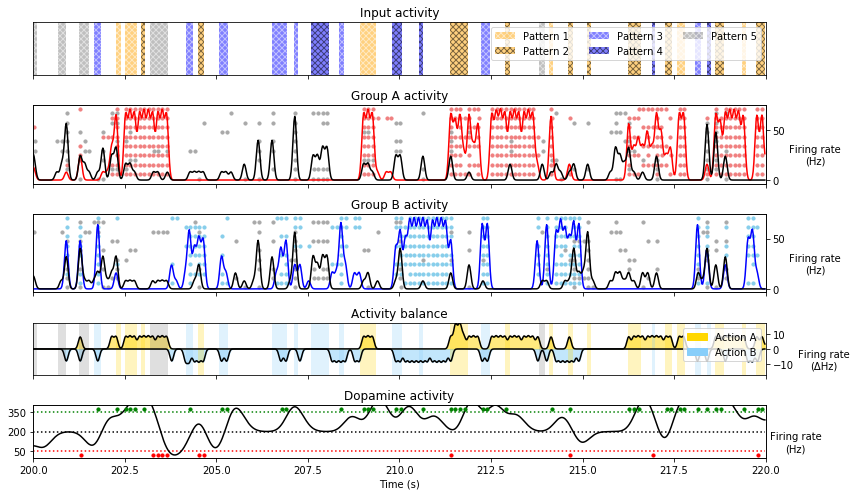

In [17]:
plot_spikes(net, 200, dt=20)
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/network_activity.svg')

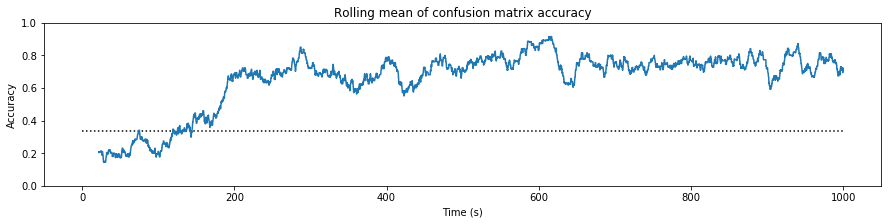

In [11]:
#@title Accuracy measurement through time

# Cálculo de la acción tomada

action_taken = np.zeros((net.n_actions+1, net.show_pattern.size))

for n_action in range(1, net.n_actions+1):
    spikes_action = net.oi==net.action_layer[n_action-1]
    for spike_time in net.ot[spikes_action]:
#         time_bin = int(spike_time//net.max_duration_pattern)
        time_bin = np.searchsorted(net.cumsum_input_duration_patterns, spike_time)-1
        action_taken[n_action, time_bin] += 1
action_taken[0, :] = (np.sum(action_taken[1:,:], axis=0)==0)# * np.max(action_taken)


# Cálculo de la acción deseada

pattern_to_action_map = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 0
}

# action_desired = np.vectorize(pattern_to_action_map.get)(net.show_pattern)
action_desired = []
for i, pattern in enumerate(net.show_pattern):
  # print(i, type(i), pattern, type(pattern))
  action_desired.append(pattern_to_action_map.get(pattern))


# Cálculo del tensor de confusion

confusion_matrix_time = np.zeros((net.n_actions+1, net.n_actions+1, net.show_pattern.size))
confusion_matrix = np.zeros((net.n_actions+1, net.n_actions+1))
for tak in range(action_taken.shape[0]):
    for t, (des,spks) in enumerate(zip(action_desired, action_taken[tak,:])):
        if des is None: continue
        confusion_matrix[des,tak] += spks>0
        confusion_matrix_time[des,tak,t] += spks>0


# Cálculo del vector traza y del vector suma

trace_time = np.zeros_like(net.show_pattern)
all_time = np.zeros_like(net.show_pattern)
for i in range(net.n_actions+1):
    trace_time = trace_time + confusion_matrix_time[i,i,:]
    for j in range(net.n_actions+1):
        all_time = all_time + confusion_matrix_time[i,j,:]

        
# # Ploteado

# plt.rcParams['figure.figsize'] = (15,3)

# time_window = 20
# trace_time_mean = moving_average(trace_time, n=time_window)
# all_time_mean = moving_average(all_time, n=time_window)
# time = net.cumsum_input_duration_patterns[:trace_time_mean.size]
# plt.plot(time, trace_time_mean / all_time_mean)
# plt.ylim((0,1))

import pandas as pd

n = 100
rm_tra = pd.Series(trace_time).rolling(n).mean()
rm_all = pd.Series(all_time).rolling(n).mean()
pre = rm_tra/rm_all
time = net.cumsum_input_duration_patterns[pre.index]

plt.rcParams['figure.figsize'] = (15,3)

# plt.fill_between(time, pre-rs_all, pre+rs_all, alpha=0.25, label='2 * Rolling std of rolling mean')
plt.plot(time, pre, label='Rolling mean')
plt.ylim((0,1))
# plt.legend()

plt.title('Rolling mean of confusion matrix accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Time (s)')

plt.hlines(3/9, time.min(), time.max(), linestyles='dotted')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/network_accuracy.svg')

# plt.xlim((0,150))